In [1]:
import numpy as np
import pandas as pd
from scipy.special import logit
from fairforest import d_tree,RandomForest
from fairforest import utils
import warnings
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import math

In [2]:
warnings.simplefilter("ignore")


In [3]:
np.random.seed(0)

In [4]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))


In [5]:
def build_dataset():
    z = np.zeros(4500)
    for j in range(4500):
        z[j] = np.random.binomial(1,0.5)
    x_correlated = np.zeros((4500,2))
    x_uncorrelated = np.zeros((4500,4))
    for j in range(4):
        for i in range (4500):
            if j < 2:
                x_correlated[i][j] = np.random.normal(((z[i])*50 +2*j), 1, 1)
            x_uncorrelated[i][j] = np.random.normal(10+i,1,1)
    x = np.concatenate((x_correlated,x_uncorrelated),axis=1)
    x = np.concatenate((x,np.reshape(z,(-1,1))),axis=1)
    b = [20,30,-40,35,0,0,50]
    noise = np.random.normal(0,1,4500)
    y = logit(NormalizeData(np.dot(x,b)) + noise.T)
    for i in range (len(y)):
        if y[i] > 0:
            y[i] = int(1)
        else:
            y[i] = int(0)
    column = []
    for i in range(7):
        column.append(str(i+1))
    dataframe = pd.DataFrame(x, columns = column)
    return dataframe,y


In [6]:
dataframe,y = build_dataset()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed: 17.2min remaining: 11.5min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 24.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed: 16.2min remaining: 10.8min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 21.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed: 22.3min remaining: 14.9min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 28.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed: 28.5min remaining: 19.0min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 37.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_

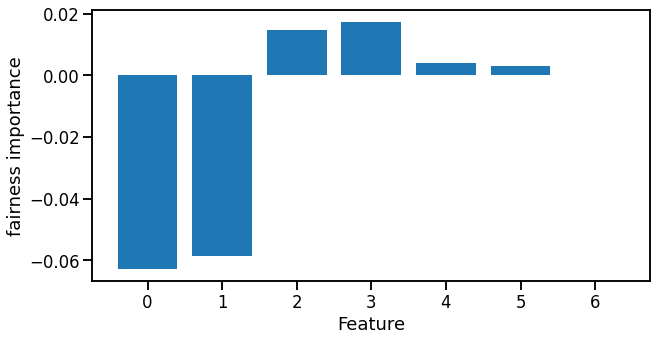

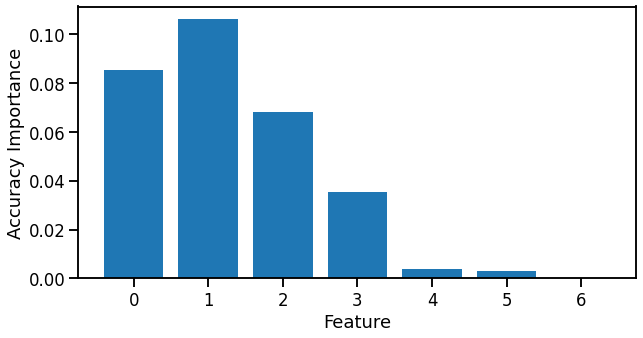

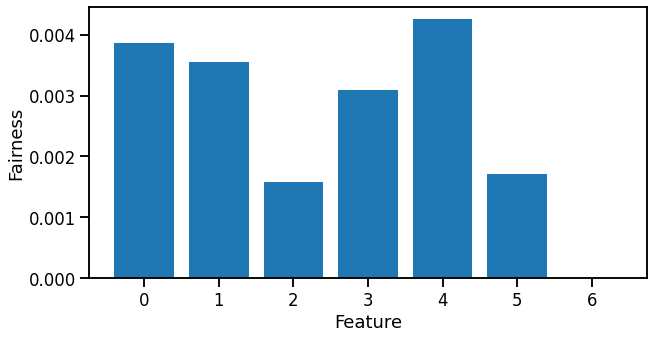

In [7]:
feature = np.arange(7)
score_fairness = np.zeros(7)
score_feature = np.zeros(7)
occlusion_fairness = np.zeros(7)
total_feature = 7
result_df = pd.DataFrame(columns=['fairness','occlusion','accuracy'])
for i in range (5):
    dataframe, y = build_dataset()
    #####protected_attribute,protected_value,protected_feature,fairness_metric
    model_dtree = RandomForest(total_feature - 1,0,str(total_feature),2,10,math.sqrt(2))
    model_dtree.fit(dataframe.copy(),y)
    sklearn_dataframe = dataframe.copy().drop(columns=[str(total_feature)])
    
    testX,testy = build_dataset()
    testX_without_protected_all = testX.copy().drop(columns=str(total_feature))
    sklearn_tree_all = RandomForestClassifier(n_estimators=10)
    sklearn_tree_all.fit(sklearn_dataframe,y)
    pred_all = sklearn_tree_all.predict(testX_without_protected_all)
    fairness_all = 1 - utils.DP(testX.to_numpy(),testy,pred_all,total_feature-1,0)
    for j in range (total_feature - 1):
        #print(j+1)
        train_data = sklearn_dataframe.copy().drop(columns=[str(j+1)])
        sklearn_tree= RandomForestClassifier(n_estimators=10)
        sklearn_tree.fit(train_data,y)
        
        testX_without_protected = testX.copy().drop(columns=[str(total_feature),str(j+1)])
        prediction = sklearn_tree.predict(testX_without_protected)
        # = fairness_all - (1 - utils.DP(testX.to_numpy(),testy,prediction,total_feature-1,0))
        occlusion_fairness[j] += fairness_all - (1 - utils.DP(testX.to_numpy(),testy,prediction,total_feature-1,0))
    fairness_importance = model_dtree._fairness_importance()
    feature_importance = model_dtree._feature_importance()
    for key, value in fairness_importance.items():
        #fairness[int(key)-1] = value
        score_fairness[int(key)-1] += value
    for key, value in feature_importance.items():
        #feature_imp[int(key)-1] = value
        score_feature[int(key)-1] += value
for i in range (7):
    score_fairness[i] /= 5
    score_feature[i] /= 5
    occlusion_fairness[i] /= 5
    result_df = result_df.append({'fairness':score_fairness[i],'occlusion':occlusion_fairness[i],'accuracy':score_feature[i]}, ignore_index=True)

result_df.to_csv("Results/synthetic_logit/results_g_DP_2000_6.csv")

utils.draw_plot(feature,score_fairness,"Results/synthetic_logit/DP_fairness1.pdf", "fairness importance")
utils.draw_plot(feature,score_feature,"Results/synthetic_logit/DP_feature1.pdf","Accuracy Importance")
utils.draw_plot(feature,occlusion_fairness,"Results/synthetic_logit/DP_fairness_occlusion1.pdf","Fairness")



In [8]:
print(occlusion_fairness)

[-0.00720519 -0.00081226 -0.00059832 -0.00125067  0.00458677  0.00010423
  0.        ]
